# Introduction
We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!  

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

My task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

This is a competition on Kaggle at the following link https://www.kaggle.com/competitions/gan-getting-started/overview. Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID). The smaller MiFID is, the better your generated images are.

## Description of dataset
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

You can download the dataset from Kaggle at following link https://www.kaggle.com/competitions/gan-getting-started/data

## Libraries Import

In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import glob
import os
import time
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization, Activation, LeakyReLU, ReLU, Reshape, Add, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError

# Exploratory Data Analysis (EDA)

In [17]:
image_size = (256,256,3)

# Path to the folder containing image files
photo_folder = 'data/gan-getting-started/photo_jpg'

# List all image file paths in the folder
photo_paths = tf.data.Dataset.list_files(os.path.join(photo_folder, '*.jpg'))
num_files = len(list(photo_paths))
print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 7038


In [18]:
# Path to the folder containing image files
monet_folder = 'data/gan-getting-started/monet_jpg'

# List all image file paths in the folder
monet_paths = tf.data.Dataset.list_files(os.path.join(monet_folder, '*.jpg'))

num_files = len(list(monet_paths))
print(f"Number of files in the folder: {num_files}")


Number of files in the folder: 300


There are 7038 photo images in the photo_jpg folder, and 300 monet painting images in the monet_jpg foler. All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. The function belows to load and preprocess the images.

In [19]:
# Define a function to load and preprocess the images
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = image*2 - 1.0
    
    return image

After defining the load and preprocess funtion, we will create two datasets for each folder. The photo_dataset contains all the images in the photo_jpg folder, and the monet_dataset contains all the images in the monet_jpg folder.

In [20]:
# Apply the load_and_preprocess_image function to each image path in the dataset
photo_dataset = photo_paths.map(load_and_preprocess_image)

# Apply the load_and_preprocess_image function to each image path in the dataset
monet_dataset = monet_paths.map(load_and_preprocess_image)

First we will visualize some of the photos from photo_dataset.

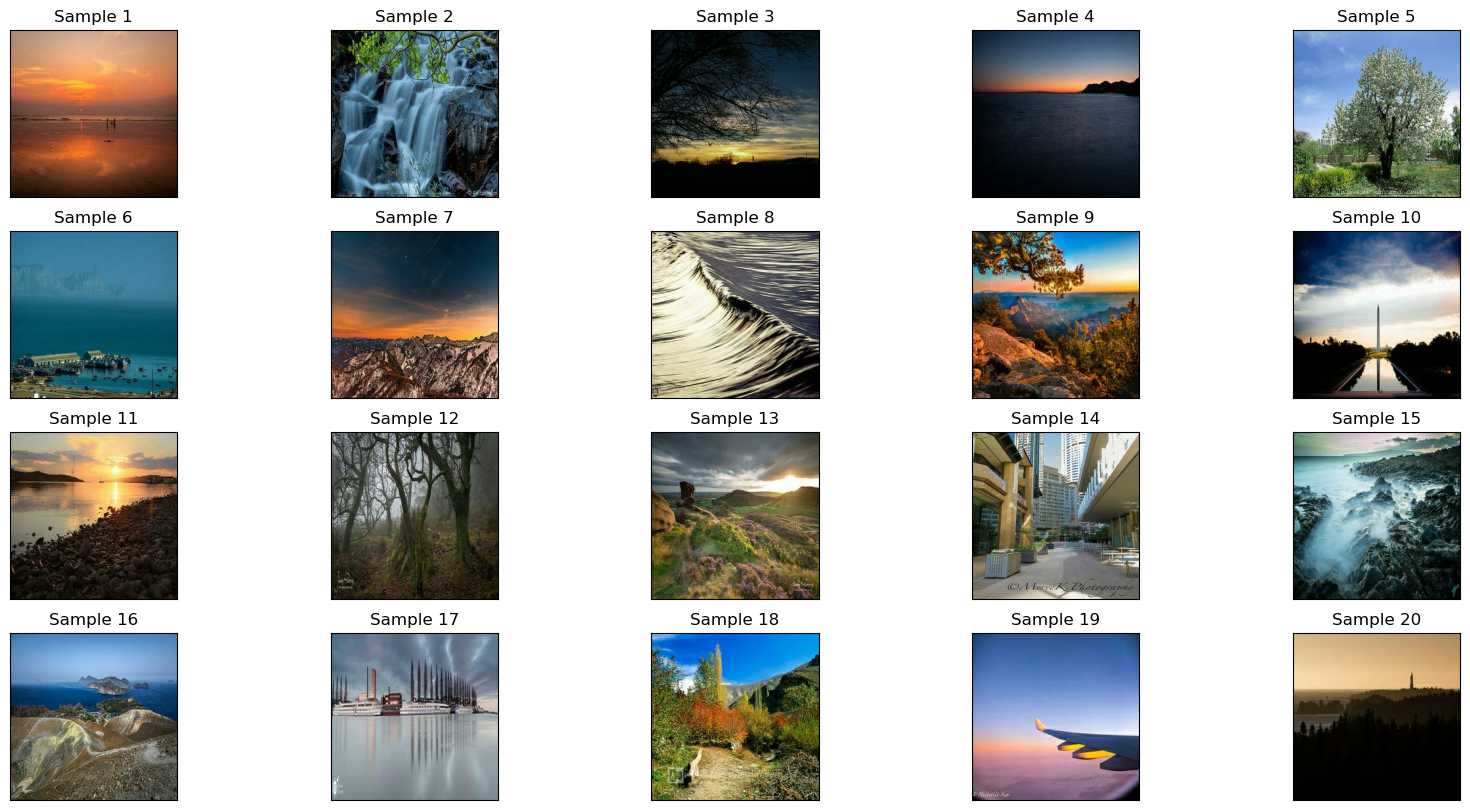

In [3]:
fig = plt.figure(figsize=(20,10))
i = 1;
for image in photo_dataset.take(20):
    ax = fig.add_subplot(4,5, i, xticks=[], yticks=[])
    img = image.numpy()
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(f'Sample {i}') 
    i+=1
plt.show()

Now we will visualize of some samples from the monet_dataset.

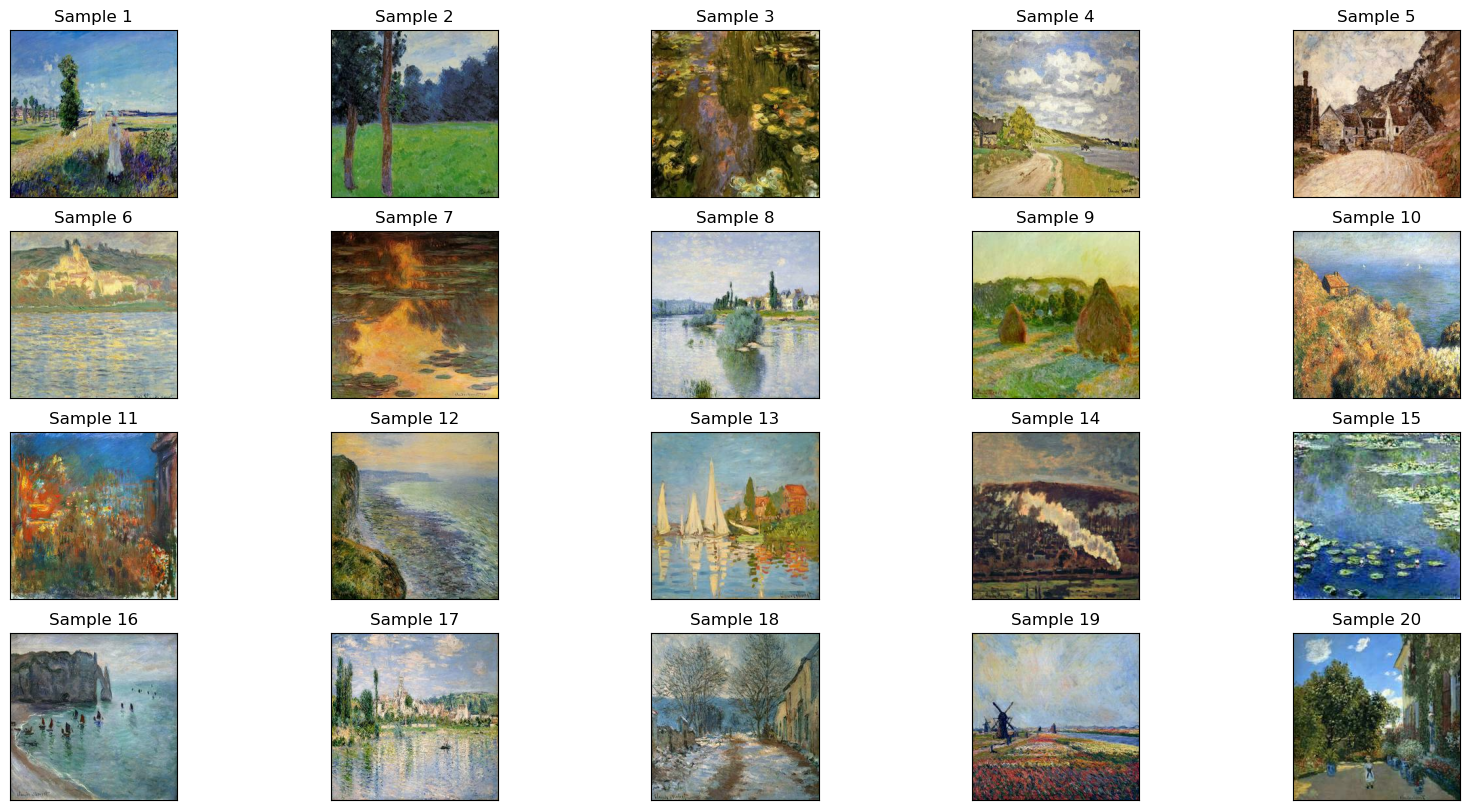

In [5]:
fig = plt.figure(figsize=(20,10))
i = 1;
for image in monet_dataset.take(20):
    ax = fig.add_subplot(4,5, i, xticks=[], yticks=[])
    img = image.numpy()
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(f'Sample {i}') 
    i+=1
plt.show()

# Models Training

### Image-to-Image Translation with Simple Pix2Pix Model.

"Image-to-Image Translation with Conditional Adversarial Nets" is a paper by Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, and Alexei A. Efros, published in 2017. This paper introduces a general framework for image-to-image translation tasks using Conditional Generative Adversarial Networks (cGANs). The authors propose a way to use cGANs to learn the mapping between images from different domains, enabling tasks such as style transfer, colorization, and many other forms of image translation.

The key contribution of the paper is the idea of using a conditional GAN, where both the generator and discriminator are conditioned on the input image. This allows for more controlled and specific image-to-image translations, where the desired output can be conditioned on the input image

In [6]:
def build_generator(image_shape):
    input_layer = Input(shape=image_shape)
    
    # Encoder
    encoder = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_layer)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    
    encoder = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    
    # Decoder
    decoder = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    decoder = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    output_layer = Conv2DTranspose(3, (7, 7), activation='tanh', padding='same')(decoder)  # Output image
    
    return Model(inputs=input_layer, outputs=output_layer)

I used two convolution layers for the encoder and two convolution layers for the decoder. By applying the stride = 2 and filter size = 4, and same padding, I was able to generate output of size (256,256,3). I also used BatchNomralization and LeakyRelu activation after each convolution layer, and finally the output layer is a 2D convolution transpose layer.

In [7]:
def build_discriminator(image_shape):
    input_layer = Input(shape=image_shape)
    
    # Layers for discriminator
    discriminator = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_layer)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    discriminator = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    discriminator = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    discriminator = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    output_layer = Conv2D(1, (4, 4), activation='sigmoid', padding='same')(discriminator)  # Output: real/fake
    
    return Model(inputs=input_layer, outputs=output_layer)

For the discriminator hidden layers, I used 4 convoluont layers with increasing feature maps, filter size is 4. The output layer of the discriminator is another convolution layer with output size 1 and sigmoid loss function to discriminate between real and fake photos.

In [8]:
# Create instances of the generators and discriminators
generator = build_generator(image_size)

discriminator = build_discriminator(image_size)

generator.summary()
discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

Now I want to define the loss function. For the loss functions, I used BinaryCrossEntropy for adversarial loss, MeanSquaredErroe for cycle loss and identity loss. These loss functions are defined in the research paper. Furthermore, I created two optimizers for generator and discriminator.

In [9]:
# Define loss functions
adversarial_loss = BinaryCrossentropy()
cycle_loss = MeanSquaredError()
identity_loss = MeanSquaredError()

# Define optimizers
generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

It's time to train our model. The architecture design and training steps are like this: First, create a fake monet using the generator. Then we used the same generator to generate a fake photo from fake monet. Then we pass the fake monet and the fake photo to the discriminator in order to trick the discriminator that those are real monets and real photos. Then we calculate losses of generator as well as discriminator, and use the optimizers to update the generator and discriminator.  

In [11]:
# Training loop
num_epochs = 100
batch_size = 1
cycle_weight = 10  # Example value for cycle weight
identity_weight = 5  # Example value for identity weight

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} started:")
    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)).batch(batch_size):
        with tf.GradientTape() as gen_tape:
            # Generate translated images
            fake_monet = generator(real_photo, training=True)
            cycled_photo = generator(fake_monet, training=True)

            # Calculate generator losses
            gen_loss_monet = adversarial_loss(tf.ones_like(discriminator(fake_monet, training=True)), discriminator(fake_monet, training=True)) + \
                         cycle_loss(real_photo, cycled_photo) * cycle_weight + \
                         identity_loss(real_photo, generator(real_photo, training=True)) * identity_weight
            
        # Calculate gradients and apply updates for generators
        gradients_of_generator = gen_tape.gradient(gen_loss_monet, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Train the discriminators
        with tf.GradientTape() as disc_tape:
            # Discriminator loss for real and fake images
            disc_loss_monet_real = adversarial_loss(tf.ones_like(discriminator(real_monet, training=True)), discriminator(real_monet, training=True))
            disc_loss_monet_fake = adversarial_loss(tf.zeros_like(discriminator(fake_monet, training=True)), discriminator(fake_monet, training=True))
            disc_loss_monet = disc_loss_monet_real + disc_loss_monet_fake
        
        # Calculate gradients and apply updates for discriminators
        gradients_of_discriminator = disc_tape.gradient(disc_loss_monet, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    end_time = time.time()       
    print('Time taken for epoch: {:.2f} seconds'.format(end_time - start_time))

Epoch 1/100 started:
Time taken for epoch: 297.01 seconds
Epoch 2/100 started:
Time taken for epoch: 296.69 seconds
Epoch 3/100 started:
Time taken for epoch: 296.16 seconds
Epoch 4/100 started:
Time taken for epoch: 297.02 seconds
Epoch 5/100 started:
Time taken for epoch: 296.93 seconds
Epoch 6/100 started:
Time taken for epoch: 296.56 seconds
Epoch 7/100 started:
Time taken for epoch: 297.01 seconds
Epoch 8/100 started:
Time taken for epoch: 297.10 seconds
Epoch 9/100 started:
Time taken for epoch: 296.01 seconds
Epoch 10/100 started:
Time taken for epoch: 296.75 seconds
Epoch 11/100 started:
Time taken for epoch: 296.49 seconds
Epoch 12/100 started:
Time taken for epoch: 297.27 seconds
Epoch 13/100 started:
Time taken for epoch: 296.49 seconds
Epoch 14/100 started:
Time taken for epoch: 296.43 seconds
Epoch 15/100 started:
Time taken for epoch: 298.68 seconds
Epoch 16/100 started:
Time taken for epoch: 296.42 seconds
Epoch 17/100 started:
Time taken for epoch: 296.22 seconds
Epoch 

Training for our model is done after 100 epochs Let's visualize the generated monet images.

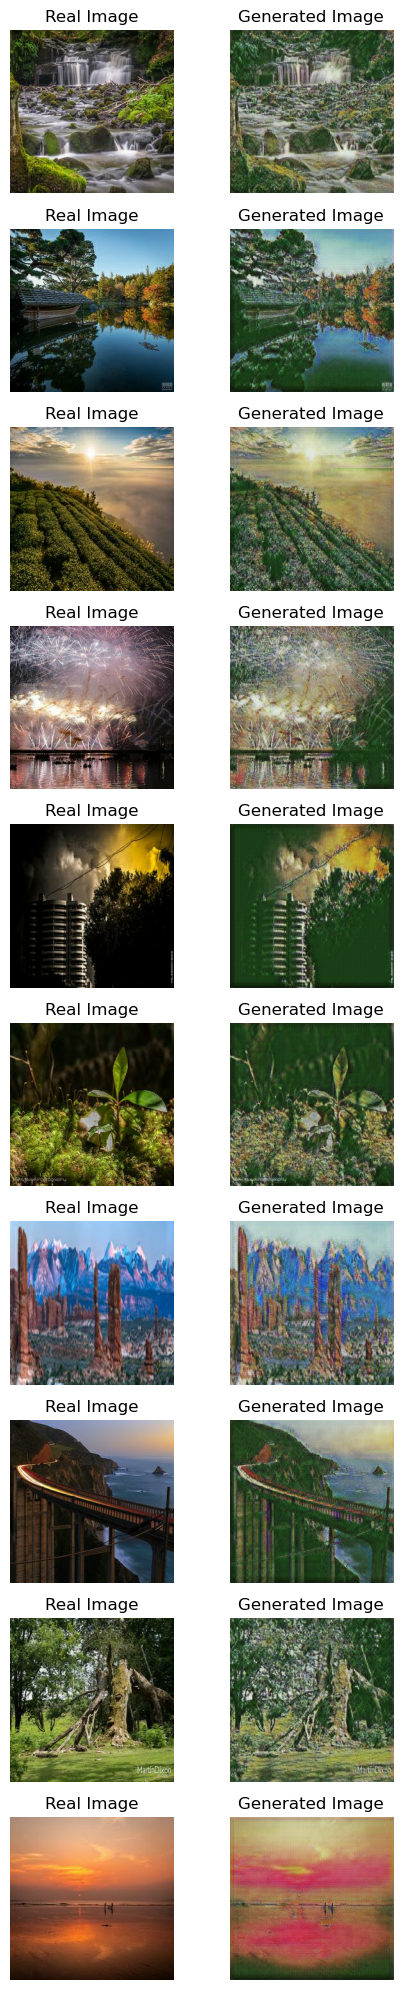

Real and generated images saved to visualization


In [21]:
num_samples_to_visualize = 10
plt.figure(figsize=(5, 20))

output_dir = 'visualization'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create an iterator over the photo_dataset
iterator = iter(photo_dataset.take(num_samples_to_visualize))

for i in range(num_samples_to_visualize):
    real_image = next(iterator)
    real_image = tf.expand_dims(real_image, axis=0)
    
    generated_image = generator(real_image, training=False)
    
    
    # Convert TensorFlow tensors to NumPy arrays and rescale to [0, 255] range
    real_image_np = ((real_image[0] + 1) / 2).numpy() * 255
    generated_image_np = ((generated_image[0] + 1) / 2).numpy() * 255
    
    # Save real image
    real_image_filename = os.path.join(output_dir, f'real_image_{i+1}.png')
    plt.imsave(real_image_filename, real_image_np.astype(np.uint8))
    
   # Save generated image
    generated_image_filename = os.path.join(output_dir, f'generated_image_{i+1}.png')
    plt.imsave(generated_image_filename, generated_image_np.astype(np.uint8))
    
    # Show real image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 1)
    plt.imshow((real_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Real Image")
    plt.axis('off')
    
    # Show generated image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 2)
    plt.imshow((generated_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Generated Image")
    plt.axis('off')
    
plt.tight_layout()
plt.show()
# Print a message when saving is complete
print(f"Real and generated images saved to {output_dir}")

### Image-to-Image Translation with Simple CycleGAN Model.

"Image-to-Image Translation with CycleGAN" is a paper by Jun-Yan Zhu, Taesung Park, Phillip Isola, and Alexei A. Efros, published in 2017. This paper introduces the CycleGAN framework, which focuses on unpaired image-to-image translation tasks. The key idea behind CycleGAN is to learn a mapping between two domains without the need for paired examples, making it more flexible for a wide range of applications.  

We do not need to rebuild our build_generator and build_discriminator functions because in depth the architecture of CycleGAN and Pix2Pixl models are very similar. The differences are the CycleGAN model uses two generators and two discriminators. (For the Pix2Pix model, only 1 generator and 1 disrciminator).

In [14]:
# Create instances of the generators and discriminators
generator_photo_to_monet = build_generator(image_size)
generator_monet_to_photo = build_generator(image_size)
discriminator_photo = build_discriminator(image_size)
discriminator_monet = build_discriminator(image_size)

generator_photo_to_monet.summary()
discriminator_monet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                           

Because we have two generators and two discriminators, we also need 4 optimizers, one for each generator or discriminator.

In [15]:
# Define optimizers
generator_optimizer_photo_to_monet = Adam(learning_rate=2e-4, beta_1=0.5)
generator_optimizer_monet_to_photo = Adam(learning_rate=2e-4, beta_1=0.5)

# Define optimizers for discriminators
discriminator_optimizer_photo = Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer_monet = Adam(learning_rate=2e-4, beta_1=0.5)

It's time to train our model. The architecture design and training steps are like this: First, create a fake monet using the generator photo to monet. Then we used generator monet to photo to generate a fake photo from fake monet. Then we pass the real monet and the fake monet to the monet discriminator in order to trick the monet discriminator that the fakes are real monets. And we also pass the real photo and fake photo to the photo discriminator in order to  trick the photo discriminators that the fakes are real photos. Then we calculate losses of generators as well as discriminators, and use the optimizers to update the generators and discriminators.  

In [16]:
# Training loop
num_epochs = 100
batch_size = 1
cycle_weight = 10  # value for cycle weight
identity_weight = 5  # value for identity weight

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} started:")
    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)).batch(batch_size):
        with tf.GradientTape(persistent = True) as gen_tape:
            # Generate translated images
            fake_monet = generator_photo_to_monet(real_photo, training=True)
            cycled_photo = generator_monet_to_photo(fake_monet, training=True)

            fake_photo = generator_monet_to_photo(real_monet, training=True)
            cycled_monet = generator_photo_to_monet(fake_photo, training=True)

            # Calculate generator losses
            gen_loss_photo = adversarial_loss(tf.ones_like(discriminator_monet(fake_monet, training=True)), discriminator_monet(fake_monet, training=True)) + \
                         cycle_loss(real_photo, cycled_photo) * cycle_weight + \
                         identity_loss(real_photo, generator_photo_to_monet(real_photo, training=True)) * identity_weight

            gen_loss_monet = adversarial_loss(tf.ones_like(discriminator_photo(fake_photo, training=True)), discriminator_photo(fake_photo, training=True)) + \
                         cycle_loss(real_monet, cycled_monet) * cycle_weight + \
                         identity_loss(real_monet, generator_monet_to_photo(real_monet, training=True)) * identity_weight

            # Calculate gradients and apply updates for generators
            gradients_of_generator_photo_to_monet = gen_tape.gradient(gen_loss_photo, generator_photo_to_monet.trainable_variables)
            generator_optimizer_photo_to_monet.apply_gradients(zip(gradients_of_generator_photo_to_monet, generator_photo_to_monet.trainable_variables))

            gradients_of_generator_monet_to_photo = gen_tape.gradient(gen_loss_monet, generator_monet_to_photo.trainable_variables)
            generator_optimizer_monet_to_photo.apply_gradients(zip(gradients_of_generator_monet_to_photo, generator_monet_to_photo.trainable_variables))


        # Train the discriminators
        with tf.GradientTape(persistent = True) as disc_tape:
            # Discriminator loss for real and fake images
            disc_loss_photo_real = adversarial_loss(tf.ones_like(discriminator_photo(real_monet, training=True)), discriminator_photo(real_monet, training=True))
            disc_loss_photo_fake = adversarial_loss(tf.zeros_like(discriminator_photo(fake_monet, training=True)), discriminator_photo(fake_monet, training=True))
            disc_loss_photo = disc_loss_photo_real + disc_loss_photo_fake

            disc_loss_monet_real = adversarial_loss(tf.ones_like(discriminator_monet(real_monet, training=True)), discriminator_monet(real_monet, training=True))
            disc_loss_monet_fake = adversarial_loss(tf.zeros_like(discriminator_monet(fake_monet, training=True)), discriminator_monet(fake_monet, training=True))
            disc_loss_monet = disc_loss_monet_real + disc_loss_monet_fake

            # Calculate gradients and apply updates for discriminators
            gradients_of_discriminator_photo = disc_tape.gradient(disc_loss_photo, discriminator_photo.trainable_variables)
            discriminator_optimizer_photo.apply_gradients(zip(gradients_of_discriminator_photo, discriminator_photo.trainable_variables))

            gradients_of_discriminator_monet = disc_tape.gradient(disc_loss_monet, discriminator_monet.trainable_variables)
            discriminator_optimizer_monet.apply_gradients(zip(gradients_of_discriminator_monet, discriminator_monet.trainable_variables))

    end_time = time.time()
    print('Time taken for epoch: {:.2f} seconds'.format(end_time - start_time))

Epoch 1/100 started:
Time taken for epoch: 610.79 seconds
Epoch 2/100 started:
Time taken for epoch: 608.92 seconds
Epoch 3/100 started:
Time taken for epoch: 607.15 seconds
Epoch 4/100 started:
Time taken for epoch: 609.51 seconds
Epoch 5/100 started:
Time taken for epoch: 609.53 seconds
Epoch 6/100 started:
Time taken for epoch: 609.39 seconds
Epoch 7/100 started:
Time taken for epoch: 607.12 seconds
Epoch 8/100 started:
Time taken for epoch: 608.18 seconds
Epoch 9/100 started:
Time taken for epoch: 610.22 seconds
Epoch 10/100 started:
Time taken for epoch: 610.95 seconds
Epoch 11/100 started:
Time taken for epoch: 609.12 seconds
Epoch 12/100 started:
Time taken for epoch: 609.01 seconds
Epoch 13/100 started:
Time taken for epoch: 609.32 seconds
Epoch 14/100 started:
Time taken for epoch: 608.51 seconds
Epoch 15/100 started:
Time taken for epoch: 609.14 seconds
Epoch 16/100 started:
Time taken for epoch: 608.12 seconds
Epoch 17/100 started:
Time taken for epoch: 609.49 seconds
Epoch 

Training for our model is done after 100 epochs Let's visualize the generated monet images.

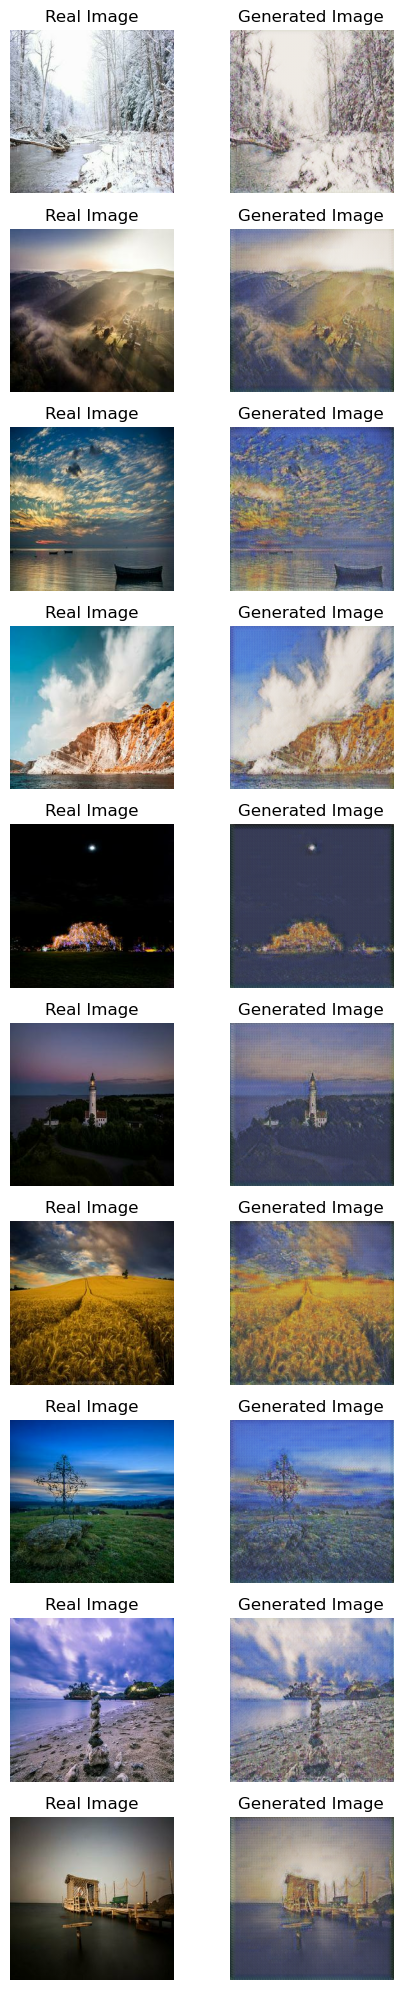

Real and generated images saved to visualization


In [24]:
num_samples_to_visualize = 10
plt.figure(figsize=(5, 20))

output_dir = 'visualization'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create an iterator over the photo_dataset
iterator = iter(photo_dataset.take(num_samples_to_visualize))

for i in range(num_samples_to_visualize):
    real_image = next(iterator)
    real_image = tf.expand_dims(real_image, axis=0)
    
    generated_image = generator_photo_to_monet(real_image, training=False)
    
    
    # Convert TensorFlow tensors to NumPy arrays and rescale to [0, 255] range
    real_image_np = ((real_image[0] + 1) / 2).numpy() * 255
    generated_image_np = ((generated_image[0] + 1) / 2).numpy() * 255
    
    # Save real image
    real_image_filename = os.path.join(output_dir, f'real_image_{i+1}.png')
    plt.imsave(real_image_filename, real_image_np.astype(np.uint8))
    
   # Save generated image
    generated_image_filename = os.path.join(output_dir, f'generated_image_{i+1}.png')
    plt.imsave(generated_image_filename, generated_image_np.astype(np.uint8))
    
    # Show real image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 1)
    plt.imshow((real_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Real Image")
    plt.axis('off')
    
    # Show generated image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 2)
    plt.imshow((generated_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Generated Image")
    plt.axis('off')
    
plt.tight_layout()
plt.show()
# Print a message when saving is complete
print(f"Real and generated images saved to {output_dir}")

### Hyperparameters Tuning
The cycle-consistency loss encourages the translated images to return to the original domain after being translated and back. The cycle weight hyperparameter, often denoted as lambda (λ), determines the importance of this loss. If the cycle weight is too high, the generator may prioritize the cycle-consistency loss over other objectives, leading to overly conservative translations. If it's too low, the model might not learn to perform accurate translations.

The identity loss encourages the generator to preserve the original image when translating it to the same domain (identity mapping). The identity weight hyperparameter, often denoted as alpha (α), controls the impact of this loss. Setting it too high may cause the generator to output images that are too similar to the original, resulting in limited transformation. Setting it too low might lead to less emphasis on preserving original content.

In [26]:
# Create instances of the generators and discriminators
gen_photo_to_monet = build_generator(image_size)
gen_monet_to_photo = build_generator(image_size)
dis_photo = build_discriminator(image_size)
dis_monet = build_discriminator(image_size)

gen_photo_to_monet.summary()
dis_monet.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_30 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                          

I have changed the learning rate from 2e-4 to 1e-5.

In [28]:
# Define optimizers
gen_optimizer_photo_to_monet = Adam(learning_rate=1e-5, beta_1=0.5)
gen_optimizer_monet_to_photo = Adam(learning_rate=1e-5, beta_1=0.5)

# Define optimizers for discriminators
dis_optimizer_photo = Adam(learning_rate=1e-5, beta_1=0.5)
dis_optimizer_monet = Adam(learning_rate=1e-5, beta_1=0.5)

Set cycle weight = 15, identity weight = 3

In [29]:
# Training loop
num_epochs = 100
batch_size = 1
cycle_weight = 15  # value for cycle weight
identity_weight = 3  # value for identity weight

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} started:")
    for real_photo, real_monet in tf.data.Dataset.zip((photo_dataset, monet_dataset)).batch(batch_size):
        with tf.GradientTape(persistent = True) as gen_tape:
            # Generate translated images
            fake_monet = gen_photo_to_monet(real_photo, training=True)
            cycled_photo = gen_monet_to_photo(fake_monet, training=True)

            fake_photo = gen_monet_to_photo(real_monet, training=True)
            cycled_monet = gen_photo_to_monet(fake_photo, training=True)

            # Calculate generator losses
            gen_loss_photo = adversarial_loss(tf.ones_like(dis_monet(fake_monet, training=True)), dis_monet(fake_monet, training=True)) + \
                         cycle_loss(real_photo, cycled_photo) * cycle_weight + \
                         identity_loss(real_photo, gen_photo_to_monet(real_photo, training=True)) * identity_weight

            gen_loss_monet = adversarial_loss(tf.ones_like(dis_photo(fake_photo, training=True)), dis_photo(fake_photo, training=True)) + \
                         cycle_loss(real_monet, cycled_monet) * cycle_weight + \
                         identity_loss(real_monet, gen_monet_to_photo(real_monet, training=True)) * identity_weight

            # Calculate gradients and apply updates for generators
            gradients_of_gen_photo_to_monet = gen_tape.gradient(gen_loss_photo, gen_photo_to_monet.trainable_variables)
            gen_optimizer_photo_to_monet.apply_gradients(zip(gradients_of_gen_photo_to_monet, gen_photo_to_monet.trainable_variables))

            gradients_of_gen_monet_to_photo = gen_tape.gradient(gen_loss_monet, gen_monet_to_photo.trainable_variables)
            gen_optimizer_monet_to_photo.apply_gradients(zip(gradients_of_gen_monet_to_photo, gen_monet_to_photo.trainable_variables))


        # Train the discriminators
        with tf.GradientTape(persistent = True) as disc_tape:
            # Discriminator loss for real and fake images
            disc_loss_photo_real = adversarial_loss(tf.ones_like(dis_photo(real_monet, training=True)), dis_photo(real_monet, training=True))
            disc_loss_photo_fake = adversarial_loss(tf.zeros_like(dis_photo(fake_monet, training=True)), dis_photo(fake_monet, training=True))
            disc_loss_photo = disc_loss_photo_real + disc_loss_photo_fake

            disc_loss_monet_real = adversarial_loss(tf.ones_like(dis_monet(real_monet, training=True)), dis_monet(real_monet, training=True))
            disc_loss_monet_fake = adversarial_loss(tf.zeros_like(dis_monet(fake_monet, training=True)), dis_monet(fake_monet, training=True))
            disc_loss_monet = disc_loss_monet_real + disc_loss_monet_fake

            # Calculate gradients and apply updates for discriminators
            gradients_of_dis_photo = disc_tape.gradient(disc_loss_photo, dis_photo.trainable_variables)
            dis_optimizer_photo.apply_gradients(zip(gradients_of_dis_photo, dis_photo.trainable_variables))

            gradients_of_dis_monet = disc_tape.gradient(disc_loss_monet, dis_monet.trainable_variables)
            dis_optimizer_monet.apply_gradients(zip(gradients_of_dis_monet, dis_monet.trainable_variables))

    end_time = time.time()
    print('Time taken for epoch: {:.2f} seconds'.format(end_time - start_time))

Epoch 1/100 started:
Time taken for epoch: 607.44 seconds
Epoch 2/100 started:
Time taken for epoch: 605.27 seconds
Epoch 3/100 started:
Time taken for epoch: 604.33 seconds
Epoch 4/100 started:
Time taken for epoch: 603.37 seconds
Epoch 5/100 started:
Time taken for epoch: 606.16 seconds
Epoch 6/100 started:
Time taken for epoch: 604.64 seconds
Epoch 7/100 started:
Time taken for epoch: 604.97 seconds
Epoch 8/100 started:
Time taken for epoch: 607.16 seconds
Epoch 9/100 started:
Time taken for epoch: 608.45 seconds
Epoch 10/100 started:
Time taken for epoch: 608.18 seconds
Epoch 11/100 started:
Time taken for epoch: 605.53 seconds
Epoch 12/100 started:
Time taken for epoch: 606.10 seconds
Epoch 13/100 started:
Time taken for epoch: 606.00 seconds
Epoch 14/100 started:
Time taken for epoch: 608.23 seconds
Epoch 15/100 started:
Time taken for epoch: 608.73 seconds
Epoch 16/100 started:
Time taken for epoch: 608.70 seconds
Epoch 17/100 started:
Time taken for epoch: 609.39 seconds
Epoch 

Tuning is done after 100 epochs. Now let's visualize some samples.

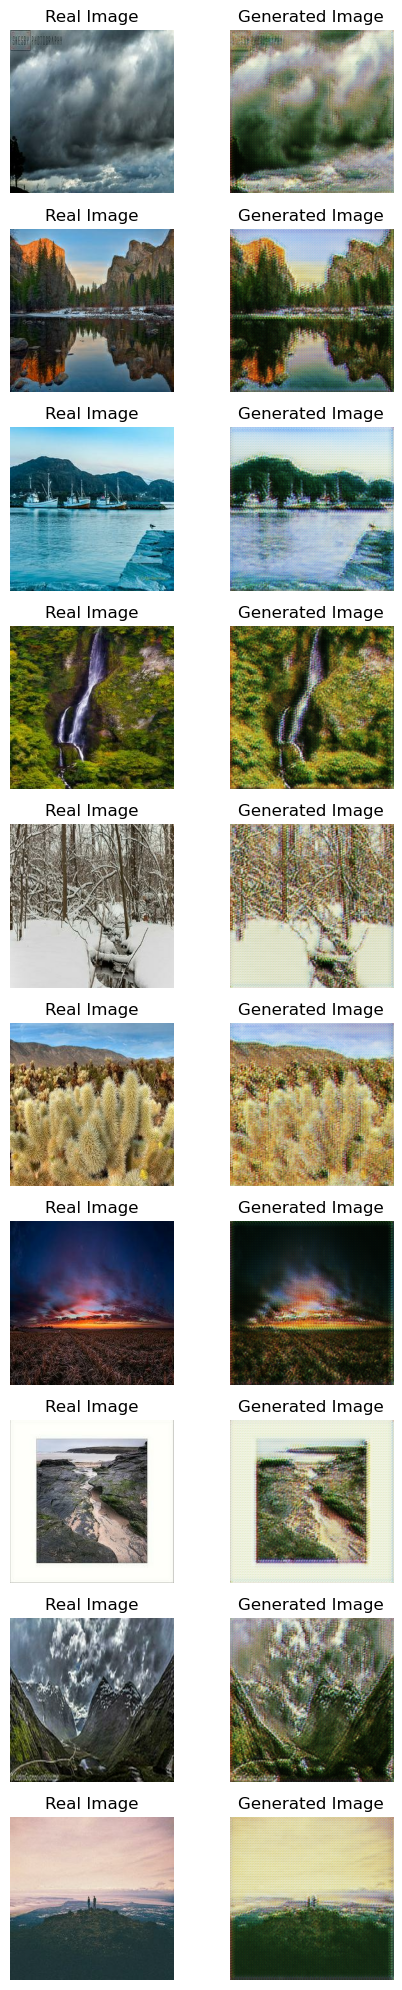

Real and generated images saved to visualization


In [30]:
num_samples_to_visualize = 10
plt.figure(figsize=(5, 20))

output_dir = 'visualization'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create an iterator over the photo_dataset
iterator = iter(photo_dataset.take(num_samples_to_visualize))

for i in range(num_samples_to_visualize):
    real_image = next(iterator)
    real_image = tf.expand_dims(real_image, axis=0)
    
    generated_image = gen_photo_to_monet(real_image, training=False)
    
    
    # Convert TensorFlow tensors to NumPy arrays and rescale to [0, 255] range
    real_image_np = ((real_image[0] + 1) / 2).numpy() * 255
    generated_image_np = ((generated_image[0] + 1) / 2).numpy() * 255
    
    # Save real image
    real_image_filename = os.path.join(output_dir, f'real_image_{i+1}.png')
    plt.imsave(real_image_filename, real_image_np.astype(np.uint8))
    
   # Save generated image
    generated_image_filename = os.path.join(output_dir, f'generated_image_{i+1}.png')
    plt.imsave(generated_image_filename, generated_image_np.astype(np.uint8))
    
    # Show real image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 1)
    plt.imshow((real_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Real Image")
    plt.axis('off')
    
    # Show generated image
    plt.subplot(num_samples_to_visualize, 2, i * 2 + 2)
    plt.imshow((generated_image[0] + 1) / 2)  # Convert back to [0, 1] range
    plt.title("Generated Image")
    plt.axis('off')
    
plt.tight_layout()
plt.show()
# Print a message when saving is complete
print(f"Real and generated images saved to {output_dir}")

The quality of generated images compared to before tuning does not seem to have better quality. We can try different values for cycle weight and identity weight to find the best generator but this step will be a lot of time consuming.

### Submission Evaluation

I will submit the CycleGAN generated images for Kaggle evaluation. First, I would need to generate all the photos from the photo folder, then I will make a zip file.  

In [31]:
# Create a directory to save predicted images
generated_output_dir = 'generated_images'
os.makedirs(generated_output_dir, exist_ok=True)

# Loop through the entire photo_dataset and save predicted images
for idx, photo in enumerate(photo_dataset):
    photo = tf.expand_dims(photo, axis=0)
    generated_image = generator_photo_to_monet(photo, training=False)
    
    # Convert TensorFlow tensor to a NumPy array and rescale to [0, 255] range
    generated_image = ((generated_image[0] + 1) / 2).numpy() * 255
    
    # Save predicted image
    generated_image_filename = os.path.join(generated_output_dir, f'generated_image_{idx+1}.jpg')
    generated_image_pil = Image.fromarray(generated_image.astype(np.uint8))
    generated_image_pil.save(generated_image_filename, format='JPEG')

# Print a message when saving predicted images is complete
print(f"Generated images saved to {generated_output_dir}")

Generated images saved to generated_images


In [32]:
import shutil

# Custom name for the zip archive
zip_archive_name = 'images'

# Create a zip archive of the directory with the custom name
shutil.make_archive(zip_archive_name, 'zip', generated_output_dir)

print(f"Zip archive '{zip_archive_name}.zip' created.")
print("Kaggle Submission Score: 37.485")

Zip archive 'images.zip' created.
Kaggle Submission Score: 37.485


# Result, Analysis and Discussion 

In [33]:
test_accuracy_list = [47.441,37.485]
data = {'MiFID':test_accuracy_list}
result_df = pd.DataFrame(data)
result_df.index = ['Pix2Pix', 'CycleGAN']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


MiFID
Pix2Pix   47.441
CycleGAN  37.485

***The table shows that a simple Pix2Pix model can do image-image translation quite well. Howevermore a more complex model like CycleGAN (though was implemented in a simple way ) can do a better job on unpaired image-image translation. In order to have a better translation, one can develop a deeper CycleGAN network or try different values with cycle weight and identity weight. For the limitations of this project, I can only do one tuning of those parameters and the results did not turn out to be better. But others are welcome to try different values to compare.*** 

## Sources

- "Image-to-Image Translation with Conditional Adversarial Nets" is a paper by Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, and Alexei A. Efros, published in 2017.
- "Image-to-Image Translation with CycleGAN" is a paper by Jun-Yan Zhu, Taesung Park, Phillip Isola, and Alexei A. Efros, published in 2017.
